## 🚧 PPE Vision 360 — Phase 2 Progress Update 🚧

### ✅ Segmentation Stage Completed (PPE Pixel-Level Precision)

I have successfully completed the **Segmentation Phase** of my **PPE Vision 360 Compliance System**.  
- Transitioned from **YOLOv8 Detection** to **YOLOv8 Segmentation** to achieve **pixel-level precision** in identifying PPE items like **Helmet, Gloves, Vest, Shoes**.
- Dataset structured with **Compliance and Non-Compliance Classes**:
  - Gloves / No-Gloves
  - Helmet / No-Helmet
  - Vest / No-Vest
  - Shoes / No-Shoes

🔍 **Outcome:**
- The model can now accurately **segment PPE items** with high mask precision.
- This segmentation output will be used to **extract individual PPE crops for Compliance Classification**.

---

### 🚀 Moving to Phase 3: PPE Compliance Classification

Next, I am proceeding to the **Compliance Classification Stage**, where I’ll:
1. **Crop segmented PPE items** (Gloves, Helmet, Vest, Shoes).
2. **Separate them into Compliant / Non-Compliant folders**.
3. Train a **Binary Classifier (EfficientNet)** for each PPE type to detect whether the PPE is **properly worn or not**.

🛠️ **Tech Stack for This Phase:**
- Data Augmentation (Albumentations)
- EfficientNetB0 Binary Classification
- TensorFlow/Keras for Model Training
- Python Automation for Cropping and Dataset Structuring

---

### 🎯 End Goal of This Phase:
Build a **Compliance Checker Module** that can classify:
- **Per-PPE Compliance (Gloves Compliant / Non-Compliant)**
- Which will later aggregate to **Per-Person Full Compliance Status** in real-time.




### Getting Dataset by Cropping and Organize PPE Items into Folders using Segmentation Data

In [ ]:
import os
import cv2

# Paths
images_path = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/images'
labels_path = '/content/drive/MyDrive/PPE-Vision/datasets/segmentation/Dataset-PPE-(Segmentation)-3/train/labels'
output_path = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/'

# Class ID Mapping from your dataset
class_map = {
    0: ('Gloves', 'Compliant'),
    1: ('Helmet', 'Compliant'),
    2: ('Gloves', 'Non_Compliant'),
    3: ('Helmet', 'Non_Compliant'),
    4: ('Shoes', 'Non_Compliant'),
    5: ('Vest', 'Non_Compliant'),
    6: ('Shoes', 'Compliant'),
    7: ('Vest', 'Compliant')
}

# Ensure Output Folders Exist
for item, status in class_map.values():
    dir_path = os.path.join(output_path, item, status)
    os.makedirs(dir_path, exist_ok=True)

# Process Each Label File
for label_file in os.listdir(labels_path):
    if not label_file.endswith('.txt'):
        continue
    image_file = label_file.replace('.txt', '.jpg')  # or .png if applicable
    img_path = os.path.join(images_path, image_file)
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(os.path.join(labels_path, label_file), 'r') as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        cx, cy, bw, bh = map(float, parts[1:5])

        # Convert to pixel coordinates
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)


        # Ensure coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        # Skip invalid crops where coordinates are bad
        if x2 <= x1 or y2 <= y1:
            print(f"Skipped invalid crop in {label_file} at index {idx}")
            continue

        # Crop the PPE item
        crop = img[y1:y2, x1:x2]

        # Skip if crop is empty (just in case)
        if crop is None or crop.size == 0:
            print(f"Skipped empty crop in {label_file} at index {idx}")
            continue

        # Save Crop in Correct Folder
        item_name, compliance_status = class_map[class_id]
        save_dir = os.path.join(output_path, item_name, compliance_status)
        save_filename = f"{label_file[:-4]}_{idx}.jpg"
        cv2.imwrite(os.path.join(save_dir, save_filename), crop)

print("Cropped PPE items have been saved successfully.")


### Glove Classification

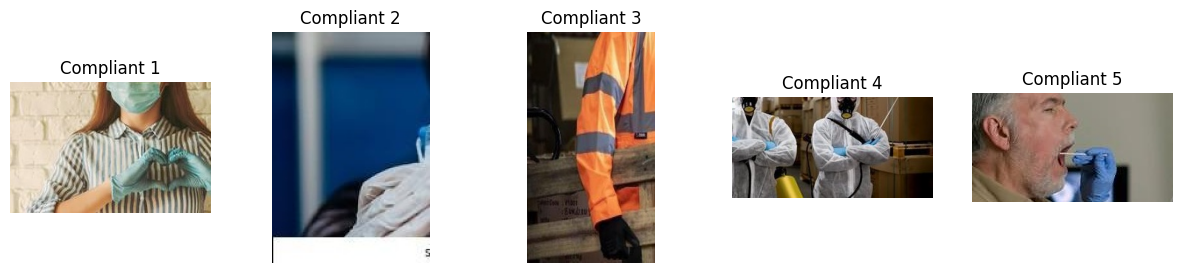

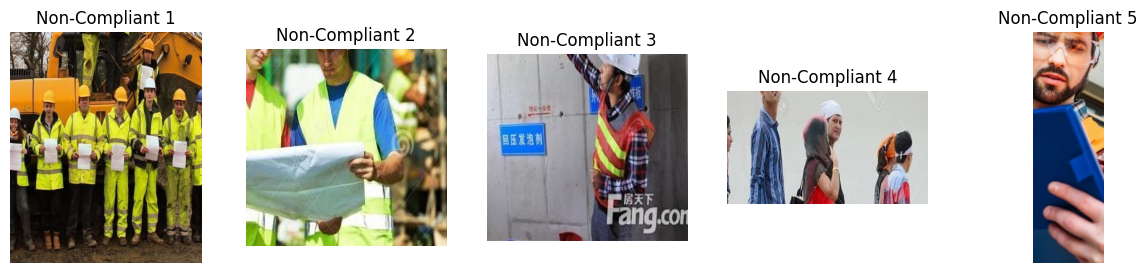

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Path to your Gloves dataset
gloves_path = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Gloves'

# Load Compliant and Non_Compliant image file paths
compliant_dir = os.path.join(gloves_path, 'Compliant')
non_compliant_dir = os.path.join(gloves_path, 'Non_Compliant')

compliant_images = [os.path.join(compliant_dir, img) for img in os.listdir(compliant_dir) if img.endswith(('.jpg', '.png'))]
non_compliant_images = [os.path.join(non_compliant_dir, img) for img in os.listdir(non_compliant_dir) if img.endswith(('.jpg', '.png'))]

# Randomly select images to visualize
num_samples = 5  # Number of images to display per class
sampled_compliant = random.sample(compliant_images, min(num_samples, len(compliant_images)))
sampled_non_compliant = random.sample(non_compliant_images, min(num_samples, len(non_compliant_images)))

# Plotting Function
def show_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {idx+1}")
    plt.show()

# Visualize Compliant Gloves
show_images(sampled_compliant, "Compliant")

# Visualize Non-Compliant Gloves
show_images(sampled_non_compliant, "Non-Compliant")


In [4]:

import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [16]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {mixed_precision.global_policy()}")

# Parameters
data_dir = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Gloves'  # Path to Glove Folder with Compliant & Non_Compliant
img_size = (224, 224)
batch_size = 32
epochs = 10
AUTOTUNE = tf.data.AUTOTUNE

# Load Dataset using tf.data API
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset="validation"
).cache().prefetch(buffer_size=AUTOTUNE)

# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32 for loss computation

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile Model with Mixed Precision Optimizer
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_glove_classifier.keras', save_best_only=True, monitor='val_loss')
]

# Train
history_gloves = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

# # Fine-Tune (Unfreeze all layers)
# for layer in base_model.layers:
#     layer.trainable = True

# # Re-compile with a lower learning rate
# opt_finetune = Adam(learning_rate=1e-4)
# model.compile(optimizer=opt_finetune, loss='binary_crossentropy', metrics=['accuracy'])

# # Fine-Tune
# model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# # Save Final Model
# model.save('gloves_compliance_classifier_final.h5')
# )



Mixed precision policy: <DTypePolicy "mixed_float16">
Found 2294 files belonging to 2 classes.
Using 1836 files for training.
Found 2294 files belonging to 2 classes.
Using 458 files for validation.
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 70s 712ms/step - accuracy: 0.6758 - loss: 0.6156 - val_accuracy: 0.9454 - val_loss: 0.2943
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8056 - loss: 0.4531 - val_accuracy: 0.9214 - val_loss: 0.3135
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8144 - loss: 0.4104 - val_accuracy: 0.9148 - val_loss: 0.2978
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8422 - loss: 0.3799 - val_accuracy: 0.9214 - val_loss: 0.2798
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8559 - loss: 0.3561 - val_accuracy: 0.9279 - val_loss: 0.2749
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8594 - loss: 0.3497 - val_accuracy: 0.9367 - val_loss: 0.2565
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━

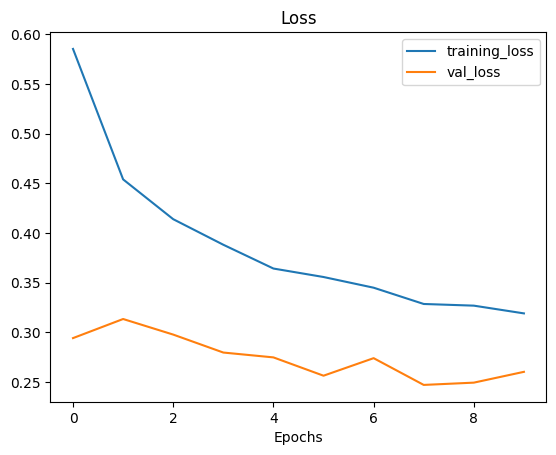

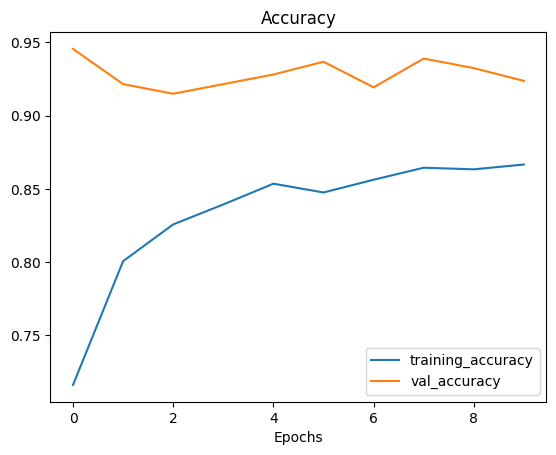

In [17]:
plot_loss_curves(history_gloves)

### Helment Classification

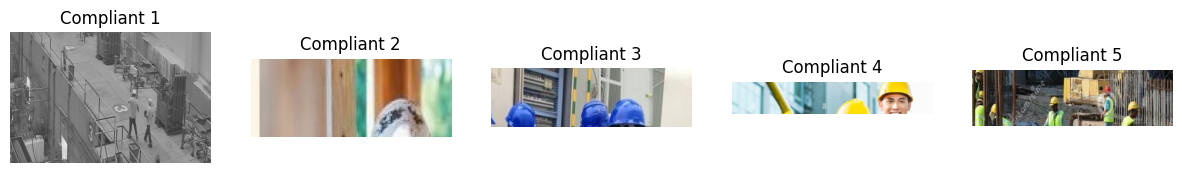

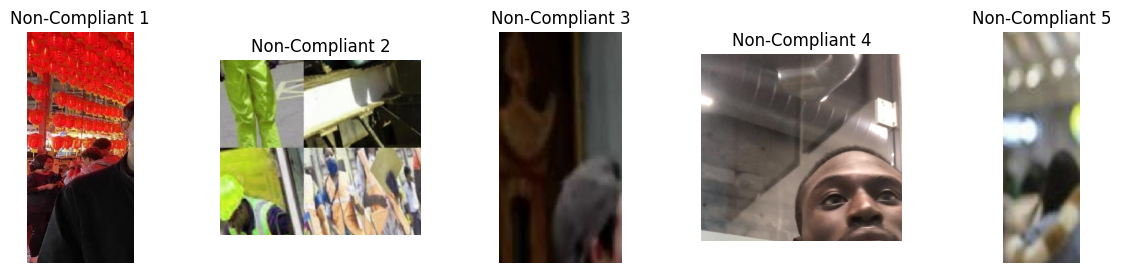

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Path to your Gloves dataset
helmet_path = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Helmet'

# Load Compliant and Non_Compliant image file paths
compliant_dir = os.path.join(gloves_path, 'Compliant')
non_compliant_dir = os.path.join(gloves_path, 'Non_Compliant')

compliant_images = [os.path.join(compliant_dir, img) for img in os.listdir(compliant_dir) if img.endswith(('.jpg', '.png'))]
non_compliant_images = [os.path.join(non_compliant_dir, img) for img in os.listdir(non_compliant_dir) if img.endswith(('.jpg', '.png'))]

# Randomly select images to visualize
num_samples = 5  # Number of images to display per class
sampled_compliant = random.sample(compliant_images, min(num_samples, len(compliant_images)))
sampled_non_compliant = random.sample(non_compliant_images, min(num_samples, len(non_compliant_images)))

# Plotting Function
def show_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {idx+1}")
    plt.show()

# Visualize Compliant Gloves
show_images(sampled_compliant, "Compliant")

# Visualize Non-Compliant Gloves
show_images(sampled_non_compliant, "Non-Compliant")


In [19]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {mixed_precision.global_policy()}")

# Parameters
data_dir = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Helmet'  # Path to Glove Folder with Compliant & Non_Compliant
img_size = (224, 224)
batch_size = 32
epochs = 10
AUTOTUNE = tf.data.AUTOTUNE

# Load Dataset using tf.data API
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset="validation"
).cache().prefetch(buffer_size=AUTOTUNE)

# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32 for loss computation

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile Model with Mixed Precision Optimizer
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_helmet_classifier.keras', save_best_only=True, monitor='val_loss')
]

# Train
history_helmet = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)



Mixed precision policy: <DTypePolicy "mixed_float16">
Found 2252 files belonging to 2 classes.
Using 1802 files for training.
Found 2252 files belonging to 2 classes.
Using 450 files for validation.
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 103s 863ms/step - accuracy: 0.5917 - loss: 0.6700 - val_accuracy: 0.6467 - val_loss: 0.6536
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.7986 - loss: 0.4694 - val_accuracy: 0.7089 - val_loss: 0.5685
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8388 - loss: 0.3939 - val_accuracy: 0.7444 - val_loss: 0.5281
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8372 - loss: 0.3796 - val_accuracy: 0.7644 - val_loss: 0.4959
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8439 - loss: 0.3539 - val_accuracy: 0.7667 - val_loss: 0.4880
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8623 - loss: 0.3279 - val_accuracy: 0.7978 - val_loss: 0.4542
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━

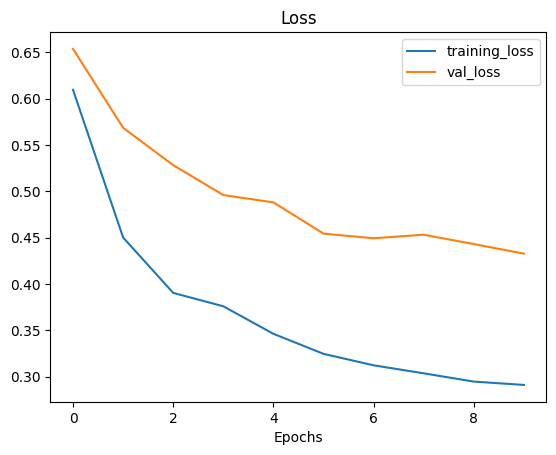

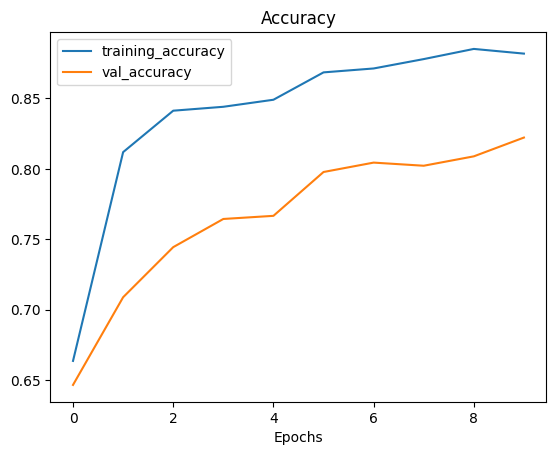

In [20]:
plot_loss_curves(history_helmet)

### Vest Classification

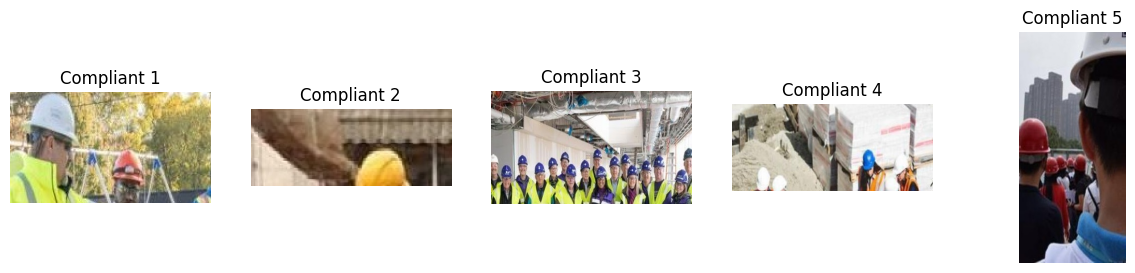

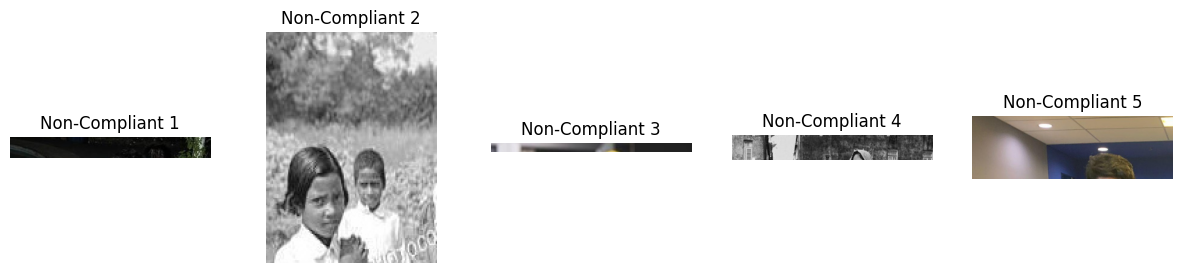

In [15]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Path to your Gloves dataset
vest_path = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Vest'

# Load Compliant and Non_Compliant image file paths
compliant_dir = os.path.join(gloves_path, 'Compliant')
non_compliant_dir = os.path.join(gloves_path, 'Non_Compliant')

compliant_images = [os.path.join(compliant_dir, img) for img in os.listdir(compliant_dir) if img.endswith(('.jpg', '.png'))]
non_compliant_images = [os.path.join(non_compliant_dir, img) for img in os.listdir(non_compliant_dir) if img.endswith(('.jpg', '.png'))]

# Randomly select images to visualize
num_samples = 5  # Number of images to display per class
sampled_compliant = random.sample(compliant_images, min(num_samples, len(compliant_images)))
sampled_non_compliant = random.sample(non_compliant_images, min(num_samples, len(non_compliant_images)))

# Plotting Function
def show_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {idx+1}")
    plt.show()

# Visualize Compliant Gloves
show_images(sampled_compliant, "Compliant")

# Visualize Non-Compliant Gloves
show_images(sampled_non_compliant, "Non-Compliant")


In [16]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {mixed_precision.global_policy()}")

# Parameters
data_dir = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Vest'  # Path to Glove Folder with Compliant & Non_Compliant
img_size = (224, 224)
batch_size = 32
epochs = 10
AUTOTUNE = tf.data.AUTOTUNE

# Load Dataset using tf.data API
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset="validation"
).cache().prefetch(buffer_size=AUTOTUNE)

# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32 for loss computation

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile Model with Mixed Precision Optimizer
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vest_classifier.keras', save_best_only=True, monitor='val_loss')
]

# Train
history_Vest = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)


Mixed precision policy: <DTypePolicy "mixed_float16">
Found 2229 files belonging to 2 classes.
Using 1784 files for training.
Found 2229 files belonging to 2 classes.
Using 445 files for validation.
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 488s 8s/step - accuracy: 0.6181 - loss: 0.6385 - val_accuracy: 0.6449 - val_loss: 0.6601
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8123 - loss: 0.4470 - val_accuracy: 0.7258 - val_loss: 0.5874
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8546 - loss: 0.3814 - val_accuracy: 0.7461 - val_loss: 0.5466
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8775 - loss: 0.3524 - val_accuracy: 0.7708 - val_loss: 0.5099
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8905 - loss: 0.3129 - val_accuracy: 0.7888 - val_loss: 0.5045
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8972 - loss: 0.3058 - val_accuracy: 0.7933 - val_loss: 0.4915
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3

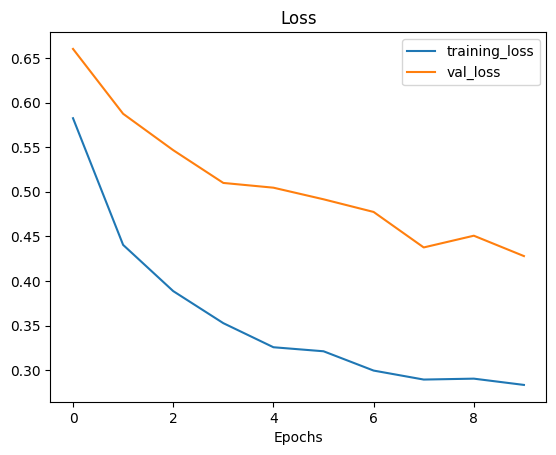

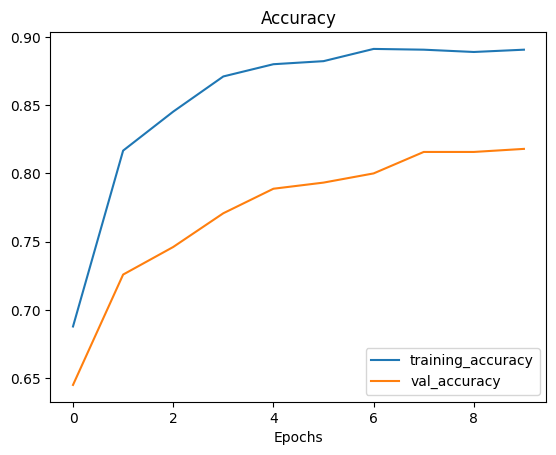

In [17]:
plot_loss_curves(history_Vest)

### Shoe Classification

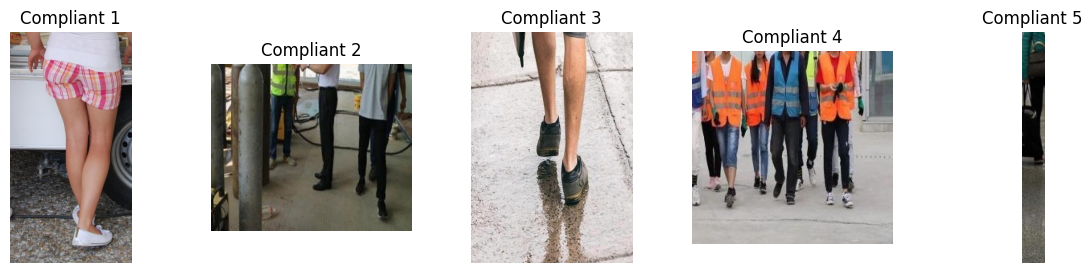

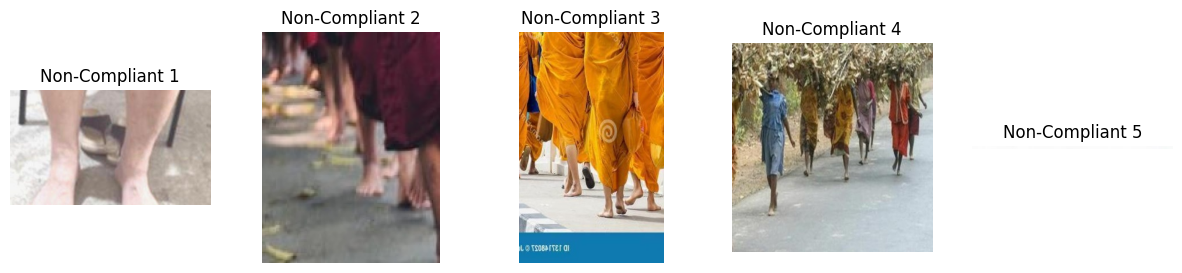

In [9]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Path to your Gloves dataset
shoes_path = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Shoes'

# Load Compliant and Non_Compliant image file paths
compliant_dir = os.path.join(gloves_path, 'Compliant')
non_compliant_dir = os.path.join(gloves_path, 'Non_Compliant')

compliant_images = [os.path.join(compliant_dir, img) for img in os.listdir(compliant_dir) if img.endswith(('.jpg', '.png'))]
non_compliant_images = [os.path.join(non_compliant_dir, img) for img in os.listdir(non_compliant_dir) if img.endswith(('.jpg', '.png'))]

# Randomly select images to visualize
num_samples = 5  # Number of images to display per class
sampled_compliant = random.sample(compliant_images, min(num_samples, len(compliant_images)))
sampled_non_compliant = random.sample(non_compliant_images, min(num_samples, len(non_compliant_images)))

# Plotting Function
def show_images(image_paths, title):
    plt.figure(figsize=(15, 3))
    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {idx+1}")
    plt.show()

# Visualize Compliant Gloves
show_images(sampled_compliant, "Compliant")

# Visualize Non-Compliant Gloves
show_images(sampled_non_compliant, "Non-Compliant")


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {mixed_precision.global_policy()}")

# Parameters
data_dir = '/content/drive/MyDrive/PPE-Vision/datasets/classification/cropped_segmentation_classifier/Shoes'  # Path to Glove Folder with Compliant & Non_Compliant
img_size = (224, 224)
batch_size = 32
epochs = 10
AUTOTUNE = tf.data.AUTOTUNE

# Load Dataset using tf.data API
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset="validation"
).cache().prefetch(buffer_size=AUTOTUNE)

# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32 for loss computation

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile Model with Mixed Precision Optimizer
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_shoe_classifier.keras', save_best_only=True, monitor='val_loss')
]

# Train
history_Shoes = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)


Mixed precision policy: <DTypePolicy "mixed_float16">
Found 1580 files belonging to 2 classes.
Using 1264 files for training.
Found 1580 files belonging to 2 classes.
Using 316 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 301s 7s/step - accuracy: 0.6544 - loss: 0.5996 - val_accuracy: 0.6835 - val_loss: 0.6113
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.8569 - loss: 0.3707 - val_accuracy: 0.7595 - val_loss: 0.4935
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8880 - loss: 0.2995 - val_accuracy: 0.8133 - val_loss: 0.4235
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8989 - loss: 0.2648 - val_accuracy: 0.8196 - val_loss: 0.3970
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9056 - loss: 0.2475 - val_accuracy: 0.8291 - val_loss: 0.3635
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9078 - loss: 0.2308 - val_accuracy: 0.8354 - val_

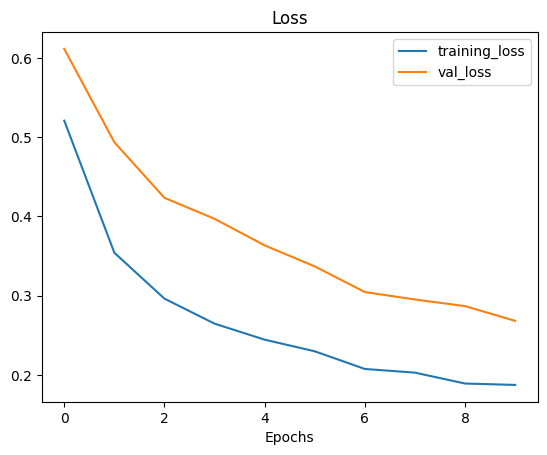

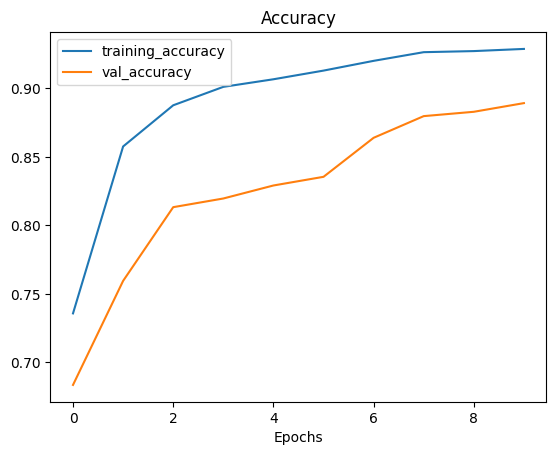

In [5]:
plot_loss_curves(history_Shoes)

## 📊 Model Training Summary — PPE Compliance Classifier (MVP)

For this MVP, I used **EfficientNetB0 as a frozen feature extractor (trainable=False)** to classify PPE items (Gloves, Helmet, Vest, Shoes) as **Compliant** or **Non-Compliant**.

### ✅ Why Freezing Base Model?
- Dataset size is still limited, so fine-tuning could cause overfitting.
- EfficientNetB0's pre-trained features are already very powerful for general patterns.
- For an MVP, freezing ensures faster training and stable performance.

### ⚙️ Training Strategy:
- Base Model: EfficientNetB0 (Frozen)
- Classifier Head: Global Average Pooling + Dropout(0.3) + Dense(sigmoid)
- Optimizer: Adam (1e-3)
- Loss: Binary Crossentropy
- Mixed Precision Enabled
- EarlyStopping and Checkpointing applied

### 📈 Performance Metrics:
| Classifier | Train Accuracy | Validation Accuracy |
|------------|----------------|---------------------|
| Gloves     | ~86%            | ~93%                |
| Helmet     | ~89%            | ~82%                |
| Vest       | ~90%            | ~81%                |
| Shoes      | ~93%            | ~89%                |

---

### 📌 Conclusion:
- **For MVP, this setup gives reliable performance for compliance checking in controlled environments.**
- **To improve further**, I plan to:
  - Collect more diverse PPE datasets.
  - Apply stronger data augmentations.
  - Fine-tune selected layers of EfficientNet progressively.
  - Scale model architecture if needed (EfficientNetB3/B4).

---
